### Deep & Cross Network 笔记

### Contributions
- 提出了一个可以得到bounded-degree 特征交叉的结构 并且不需要手动的特征工程；
- 实验结果显示 在准确率和内存使用上 比 DNN 效果更好；

#### Start Point
- Identifying frequently predictive features and at the same time exploring unseen or rare cross features is the key to making good predictions.
- Manual feature engineering is exhaustive.
- We want to apply feature crossing in an automatic fashion.


### Related Work
#### FMs & FFMs
- Factorization machines (FMs) project sparse features onto low-dimensional dense vectors and learn feature interactions from vector inner products.
- Field-aware factorization machines (FFMs) further allow each feature to learn several vectors where each vector is associated with a field.
- The shallow structures of FMs and FFMs limit their representative power.
#### DNN
- Deep neural networks (DNN) are able to learn non-trivial high-degree feature interactions due to embedding vectors and nonlinear activation functions.
- There has been research showing that DNNs are able to approximate an arbitrary function under certain smoothness assumptions to an arbitrary accuracy, given sufficiently many hidden units or hidden layers.
- The manually crafted features in many winning solutions are low-degree, in an explicit format and effective. DNNs are not indeed the most efficient ones in representing such functions of practical interest.


### the Architecture of Deep Cross Network
![Alt text](./figures/image.png)

A DCN model starts with an embedding and stacking layer, followed by a cross network and a deep network in parallel. These in turn are followed by a final combination layer which combines the outputs from the two networks.

### Cross Network
The key idea of cross network is to apply explicit feature crossing in an efficient way.
$$
x_{l+1} = x_0x_l^Tw_l+b_l+x_l = f(x_l, w_l, b_l) + x_l
$$
where $x_l,x_{l+1} \in R^d$ are column vectors denoting the outputs from the l-th and (l+1)-th cross layers; $w_l,b_l \in R^d$ are the weight and bias parameters of the l-th layer. 

- **High-degree Interaction Across Features**: the degree of cross features grows with layer depth. The highest polynomial degree (in terms of input $x_0$) for an l-layer cross network is $l+1$. In fact, the cross network comprises all the cross terms $x_1^{\alpha_1}, \cdots x_d^{\alpha_d}$ of degree from 1 to l+1.

- **Complexity Analysis**: Let $L_c$ denote the number of cross layers, and $d$ denote the input dimension. Then, the number of parameters involved in the cross network is 
$$
d \times L_c \times 2
$$
The time and space complexity of a cross network are $O(d)$. The small number of parameters of the cross network has limited the model capacity. To capture highly nonlinear interactions, a deep network should be utilized in parallel.

### Combination Layer
The combination layer concatenates the outputs from two networks and feed the concatenated vector into a standard logits layer.
$$
p = \sigma([x_{L_1}^T, h_{L_2}^T]w_{logits})
$$
where $x_{L_1} \in R^d, h_{L_2} \in R^m$ are the outputs from the cross network and deep network, respectively, $w_{logits} \in R^{(d+m)}$ is the weight vector for the combination layer, and $\sigma(x) = 1/(1+exp(-x))$.

The loss function is the log loss along with a regularization term,
$$
\text{loss} = -\frac{1}{N}\sum_{i=1}^Ny_i\text{log}(p_i) + (1-y_i)\text{log}(1-p_i) + \lambda \sum_{l} \|w_l\|^2
$$
Jointly train both networks, as this allows each individual network to be aware of the others during the training.

## Model from tensorflow tutorials (DCN V2)

In [2]:
import pprint

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

import tensorflow_recommenders as tfrs

In [95]:
ratings = tfds.load("movie_lens/100k-ratings", split="train")
ratings = ratings.map(lambda x: {
    "movie_id": x["movie_id"],
    "user_id": x["user_id"],
    "user_rating": x["user_rating"],
    "user_gender": int(x["user_gender"]),
    "user_zip_code": x["user_zip_code"],
    "user_occupation_text": x["user_occupation_text"],
    "bucketized_user_age": int(x["bucketized_user_age"]),
})

In [96]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(100_000, seed=42, reshuffle_each_iteration=False)

train = shuffled.take(80_000)
test = shuffled.skip(80_000).take(20_000)

In [97]:
feature_names = ["movie_id", "user_id", "user_gender", "user_zip_code",
                 "user_occupation_text", "bucketized_user_age"]

vocabularies = {}

for feature_name in feature_names:
  vocab = ratings.batch(1_000_000).map(lambda x: x[feature_name])
  vocabularies[feature_name] = np.unique(np.concatenate(list(vocab)))

In [6]:
class DCN(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, projection_dim=None):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])

    if use_cross_layer:
      self._cross_layer = tfrs.layers.dcn.Cross(
          projection_dim=projection_dim,
          kernel_initializer="glorot_uniform")
    else:
      self._cross_layer = None

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    if self._cross_layer is not None:
      x = self._cross_layer(x)

    # Build Deep Network
    for deep_layer in self._deep_layers:
      x = deep_layer(x)

    return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

In [98]:
cached_train = train.shuffle(100_000).batch(8192).cache()
cached_test = test.batch(4096).cache()

In [9]:
epochs = 8
learning_rate = 0.01

In [10]:
def run_models(use_cross_layer, deep_layer_sizes, projection_dim=None, num_runs=5):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DCN(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                projection_dim=projection_dim)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    models.append(model)

    model.fit(cached_train, epochs=epochs, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv}

In [11]:
dcn_result = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192])

2023-10-15 20:53:10.567141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-15 20:53:18.347605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 60ms/step - RMSE: 0.9315 - loss: 0.8690 - regularization_loss: 0.0000e+00 - total_loss: 0.8690


2023-10-15 20:53:20.544594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 19ms/step - RMSE: 0.9322 - loss: 0.8689 - regularization_loss: 0.0000e+00 - total_loss: 0.8689


2023-10-15 20:53:25.199463: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-15 20:53:25.839153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 19ms/step - RMSE: 0.9324 - loss: 0.8693 - regularization_loss: 0.0000e+00 - total_loss: 0.8693


2023-10-15 20:53:30.506602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-15 20:53:31.231096: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 24ms/step - RMSE: 0.9282 - loss: 0.8618 - regularization_loss: 0.0000e+00 - total_loss: 0.8618


2023-10-15 20:53:36.043329: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-15 20:53:36.726453: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 22ms/step - RMSE: 0.9302 - loss: 0.8654 - regularization_loss: 0.0000e+00 - total_loss: 0.8654


2023-10-15 20:53:41.670843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [12]:
dcn_lr_result = run_models(use_cross_layer=True,
                           projection_dim=20,
                           deep_layer_sizes=[192, 192])

2023-10-15 20:53:58.928448: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 0s - RMSE: 0.9372 - loss: 0.8784 - regularization_loss: 0.0000e+00 - total_loss: 0.8784

2023-10-15 20:54:04.489967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 28ms/step - RMSE: 0.9310 - loss: 0.8670 - regularization_loss: 0.0000e+00 - total_loss: 0.8670


2023-10-15 20:54:05.353342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 0s - RMSE: 0.9364 - loss: 0.8768 - regularization_loss: 0.0000e+00 - total_loss: 0.8768

2023-10-15 20:54:10.407252: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 24ms/step - RMSE: 0.9304 - loss: 0.8662 - regularization_loss: 0.0000e+00 - total_loss: 0.8662


2023-10-15 20:54:11.077050: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 0s - RMSE: 0.9370 - loss: 0.8780 - regularization_loss: 0.0000e+00 - total_loss: 0.8780

2023-10-15 20:54:16.182946: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 27ms/step - RMSE: 0.9313 - loss: 0.8678 - regularization_loss: 0.0000e+00 - total_loss: 0.8678


2023-10-15 20:54:16.880880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 0s - RMSE: 0.9372 - loss: 0.8784 - regularization_loss: 0.0000e+00 - total_loss: 0.8784

2023-10-15 20:54:22.200053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 33ms/step - RMSE: 0.9318 - loss: 0.8687 - regularization_loss: 0.0000e+00 - total_loss: 0.8687


2023-10-15 20:54:23.106108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/5 [=======================>......] - ETA: 0s - RMSE: 0.9340 - loss: 0.8724 - regularization_loss: 0.0000e+00 - total_loss: 0.8724

2023-10-15 20:54:28.561051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 33ms/step - RMSE: 0.9343 - loss: 0.8734 - regularization_loss: 0.0000e+00 - total_loss: 0.8734


In [13]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

2023-10-15 20:54:38.767272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 0s - RMSE: 0.9390 - loss: 0.8817 - regularization_loss: 0.0000e+00 - total_loss: 0.8817

2023-10-15 20:54:44.667967: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 29ms/step - RMSE: 0.9365 - loss: 0.8778 - regularization_loss: 0.0000e+00 - total_loss: 0.8778


2023-10-15 20:54:45.387870: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/5 [=======================>......] - ETA: 0s - RMSE: 0.9436 - loss: 0.8903 - regularization_loss: 0.0000e+00 - total_loss: 0.8903

2023-10-15 20:54:51.186266: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 33ms/step - RMSE: 0.9441 - loss: 0.8924 - regularization_loss: 0.0000e+00 - total_loss: 0.8924


2023-10-15 20:54:51.900284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 0s - RMSE: 0.9381 - loss: 0.8799 - regularization_loss: 0.0000e+00 - total_loss: 0.8799

2023-10-15 20:54:57.817350: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 36ms/step - RMSE: 0.9331 - loss: 0.8717 - regularization_loss: 0.0000e+00 - total_loss: 0.8717


2023-10-15 20:54:58.787351: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/5 [=====>........................] - ETA: 0s - RMSE: 0.9406 - loss: 0.8847 - regularization_loss: 0.0000e+00 - total_loss: 0.8847

2023-10-15 20:55:04.830157: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 38ms/step - RMSE: 0.9375 - loss: 0.8796 - regularization_loss: 0.0000e+00 - total_loss: 0.8796


2023-10-15 20:55:05.593265: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


4/5 [=======================>......] - ETA: 0s - RMSE: 0.9373 - loss: 0.8785 - regularization_loss: 0.0000e+00 - total_loss: 0.8785

2023-10-15 20:55:11.475879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 0s 31ms/step - RMSE: 0.9378 - loss: 0.8802 - regularization_loss: 0.0000e+00 - total_loss: 0.8802


In [14]:
print("DCN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_result["mean"], dcn_result["stdv"]))
print("DCN (low-rank) RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dcn_lr_result["mean"], dcn_lr_result["stdv"]))
print("DNN            RMSE mean: {:.4f}, stdv: {:.4f}".format(
    dnn_result["mean"], dnn_result["stdv"]))

DCN            RMSE mean: 0.9309, stdv: 0.0016
DCN (low-rank) RMSE mean: 0.9318, stdv: 0.0014
DNN            RMSE mean: 0.9378, stdv: 0.0036


/var/folders/ss/0w045x5d6yxfp25rw38cxp3w0000gn/T/ipykernel_12373/1244897914.py:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
/var/folders/ss/0w045x5d6yxfp25rw38cxp3w0000gn/T/ipykernel_12373/1244897914.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_yticklabels([""] + features, fontsize=10)


<Figure size 900x900 with 0 Axes>

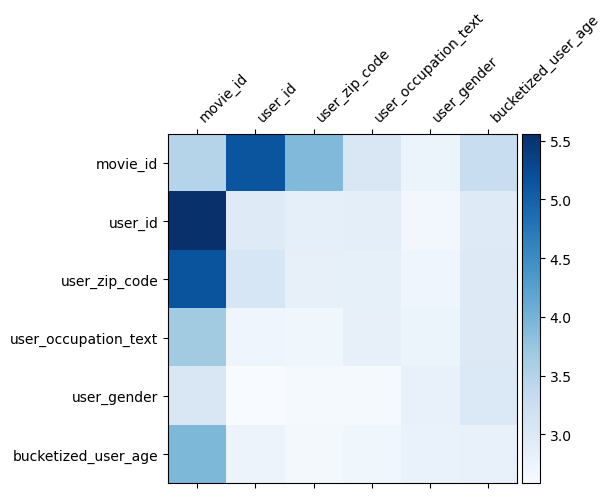

In [15]:
model = dcn_result["model"][0]
mat = model._cross_layer._dense.kernel
features = model._all_features

block_norm = np.ones([len(features), len(features)])

dim = model.embedding_dimension

# Compute the norms of the blocks.
for i in range(len(features)):
  for j in range(len(features)):
    block = mat[i * dim:(i + 1) * dim,
                j * dim:(j + 1) * dim]
    block_norm[i,j] = np.linalg.norm(block, ord="fro")

plt.figure(figsize=(9,9))
im = plt.matshow(block_norm, cmap=plt.cm.Blues)
ax = plt.gca()
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)
cax.tick_params(labelsize=10) 
_ = ax.set_xticklabels([""] + features, rotation=45, ha="left", fontsize=10)
_ = ax.set_yticklabels([""] + features, fontsize=10)

## DCN V1

In [43]:
# view the train dataset
sample_dataset = cached_train.take(1)
for example in sample_dataset:
    print(list(example.keys()))
    print(example['user_id'].shape)

# view the embedding
vocabulary = vocabularies['user_id']
emb_layer = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1, 32)
    ])
for example in sample_dataset:
    sample_emb = emb_layer(example['user_id'])
    print(sample_emb.shape)

['movie_id', 'user_id', 'user_rating', 'user_gender', 'user_zip_code', 'user_occupation_text', 'bucketized_user_age']
(8192,)
32


In [174]:
# the struct of cross layer (DCN v1)
class cross_layer():
    def __init__(self, kernal_size, bias_size, name = "default"):
        # self.initializer = tf.keras.initializers.LecunNormal(seed=hash("lucky"))
        # self.initializer = tf.keras.initializers.HeNormal(seed=hash("lucky"))
        self.initializer = tf.keras.initializers.TruncatedNormal(mean=0., stddev=0.01, seed=hash("lucky"))
        self.kernal_size = kernal_size
        self.bias_size = bias_size
        self.weight = tf.Variable(self.initializer(shape=self.kernal_size))
        self.bias = tf.Variable(self.initializer(shape=self.bias_size))
        self.layer_name = name

    def call(self, raw_input, last_output):
        weight_1 = tf.matmul(a = last_output, b = self.weight)
        product = tf.matmul(a = raw_input, b = weight_1, transpose_a=True)
        product = tf.transpose(product)
        output = product + last_output + self.bias
        return output
    
cross_layer_1 = cross_layer((32,1), (1, 32), "cross_layer_1")
for example in sample_dataset:
    sample_emb = emb_layer(example['user_id'])
    output = cross_layer_1.call(sample_emb, sample_emb)
    print(output.shape)

(8192, 32)


In [175]:
class DCN_v1(tfrs.Model):

  def __init__(self, use_cross_layer, deep_layer_sizes, cross_layer_num, struct_type="stack"):
    super().__init__()

    self.embedding_dimension = 32

    str_features = ["movie_id", "user_id", "user_zip_code",
                    "user_occupation_text"]
    int_features = ["user_gender", "bucketized_user_age"]

    self._all_features = str_features + int_features
    self._embeddings = {}

    self.total_emb_dimension = 0
    self.cross_layer_num = cross_layer_num

    # Compute embeddings for string features.
    for feature_name in str_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.StringLookup(
              vocabulary=vocabulary, mask_token=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      self.total_emb_dimension = self.total_emb_dimension + self.embedding_dimension

    # Compute embeddings for int features.
    for feature_name in int_features:
      vocabulary = vocabularies[feature_name]
      self._embeddings[feature_name] = tf.keras.Sequential(
          [tf.keras.layers.IntegerLookup(
              vocabulary=vocabulary, mask_value=None),
           tf.keras.layers.Embedding(len(vocabulary) + 1,
                                     self.embedding_dimension)
    ])
      self.total_emb_dimension = self.total_emb_dimension + self.embedding_dimension

    if use_cross_layer:
      self._cross_layers = [cross_layer(kernal_size=(self.total_emb_dimension, 1), 
                                       bias_size=(1,self.total_emb_dimension),
                                       name="cross_layer_"+str(layer)) for layer in range(self.cross_layer_num)]
    else:
      self._cross_layers = []

    self._deep_layers = [tf.keras.layers.Dense(layer_size, activation="relu")
      for layer_size in deep_layer_sizes]

    self._logit_layer = tf.keras.layers.Dense(1)

    self.struct_type = struct_type

    self.task = tfrs.tasks.Ranking(
      loss=tf.keras.losses.MeanSquaredError(),
      metrics=[tf.keras.metrics.RootMeanSquaredError("RMSE")]
    )

  def call(self, features):
    # Concatenate embeddings
    embeddings = []
    for feature_name in self._all_features:
      embedding_fn = self._embeddings[feature_name]
      embeddings.append(embedding_fn(features[feature_name]))

    x = tf.concat(embeddings, axis=1)

    # Build Cross Network
    x_last = x
    for cross_layer_ in self._cross_layers:
      x_last = cross_layer_.call(x, x_last)
      
    # Build Deep Network
    if self.struct_type == "stack":
      if self._cross_layers is not None:
        x_last = tf.concat([x, x_last], axis=1)
      for deep_layer in self._deep_layers:
        x_last = deep_layer(x_last)
      return self._logit_layer(x_last)
    else:
      if self._cross_layers is not None:
        x = tf.concat([x, x_last], axis=1)
      for deep_layer in self._deep_layers:
        x = deep_layer(x)
      combine_layer = [x_last, x]
      x = tf.concat(combine_layer, axis=1)
      return self._logit_layer(x)

  def compute_loss(self, features, training=False):
    labels = features.pop("user_rating")
    scores = self(features)
    return self.task(
        labels=labels,
        predictions=scores,
    )

In [176]:
epochs = 8
learning_rate = 1e-2

In [177]:
def run_models(use_cross_layer, deep_layer_sizes, cross_layer_num=3, struct_type="stack", num_runs=5):
  models = []
  rmses = []

  for i in range(num_runs):
    model = DCN_v1(use_cross_layer=use_cross_layer,
                deep_layer_sizes=deep_layer_sizes,
                cross_layer_num=cross_layer_num,
                struct_type=struct_type)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate))
    models.append(model)

    model.fit(cached_train, epochs=epochs, verbose=False)
    metrics = model.evaluate(cached_test, return_dict=True)
    rmses.append(metrics["RMSE"])

  mean, stdv = np.average(rmses), np.std(rmses)

  return {"model": models, "mean": mean, "stdv": stdv}

In [178]:
dcn_result_parallel = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192, 192],
                        cross_layer_num=1,
                        struct_type="parallel",
                        num_runs=3)

2023-10-29 15:15:36.218244: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:16:09.161721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 3s 440ms/step - RMSE: 2.9331 - loss: 8.9683 - regularization_loss: 0.0000e+00 - total_loss: 8.9683


2023-10-29 15:16:12.348933: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:16:40.293051: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 355ms/step - RMSE: 1.7099 - loss: 3.0771 - regularization_loss: 0.0000e+00 - total_loss: 3.0771


2023-10-29 15:16:45.938247: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:17:11.928325: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 3s 442ms/step - RMSE: 1.6755 - loss: 2.8938 - regularization_loss: 0.0000e+00 - total_loss: 2.8938


In [171]:
dcn_result_stack = run_models(use_cross_layer=True,
                        deep_layer_sizes=[192, 192],
                        cross_layer_num=1,
                        num_runs=3)

2023-10-29 15:08:13.921721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:08:38.635156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 3s 287ms/step - RMSE: 2.1984 - loss: 4.9131 - regularization_loss: 0.0000e+00 - total_loss: 4.9131


2023-10-29 15:08:41.683694: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:09:05.323220: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 217ms/step - RMSE: 1.9380 - loss: 3.8429 - regularization_loss: 0.0000e+00 - total_loss: 3.8429


2023-10-29 15:09:07.430880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:09:33.499048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 3s 400ms/step - RMSE: 2.0623 - loss: 4.3816 - regularization_loss: 0.0000e+00 - total_loss: 4.3816


In [172]:
dnn_result = run_models(use_cross_layer=False,
                        deep_layer_sizes=[192, 192, 192])

2023-10-29 15:09:36.559853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:10:00.840343: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 268ms/step - RMSE: 0.9371 - loss: 0.8793 - regularization_loss: 0.0000e+00 - total_loss: 0.8793


2023-10-29 15:10:03.611264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:10:26.331151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 373ms/step - RMSE: 0.9418 - loss: 0.8878 - regularization_loss: 0.0000e+00 - total_loss: 0.8878


2023-10-29 15:10:29.252441: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:10:56.381340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 3s 310ms/step - RMSE: 0.9376 - loss: 0.8800 - regularization_loss: 0.0000e+00 - total_loss: 0.8800


2023-10-29 15:10:59.623827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:11:26.669857: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 4s 379ms/step - RMSE: 0.9374 - loss: 0.8796 - regularization_loss: 0.0000e+00 - total_loss: 0.8796


2023-10-29 15:11:30.280057: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-10-29 15:11:57.656912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 2s 357ms/step - RMSE: 0.9375 - loss: 0.8798 - regularization_loss: 0.0000e+00 - total_loss: 0.8798
